In [2]:
library(fgsea)
library(data.table)
library(ggplot2)
library(Seurat)
library(dplyr)
library(tidyverse)
library(presto)
library(patchwork)
library(ggpubr)
library(forcats)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.0     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.tabl

In [2]:
##fgsea uses entrez IDs (number codes instead of gene IDs, e.g. CD14) so you need to convert the 
##gene ID to entrez ID 

library("biomaRt")
ensembl = useMart("ensembl", dataset="hsapiens_gene_ensembl")

t2g<-biomaRt::getBM(attributes=c("external_gene_name", "entrezgene_id"),mart=ensembl)

In [3]:
#import the gene set pathways - use Hallmark dataset

library(msigdbr)
all_gene_sets = msigdbr(species = "Homo sapiens")
h_gene_sets = msigdbr(species = "human", category = "H")
human_pathway_sets<- h_gene_sets %>% split(x = .$gene_symbol, f = .$gs_name)


In [4]:
temp<-all_gene_sets %>% filter(gs_cat == 'C2') %>% filter(grepl("ANTIGEN",gs_name))

antigen_pathways<- temp %>% filter(gs_name %in% c('REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION',                                              
                                                 'REACTOME_CLASS_I_MHC_MEDIATED_ANTIGEN_PROCESSING_PRESENTATION',
                                                 'REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION'))


antigen_pathways <- antigen_pathways %>% split(x = .$gene_symbol, f = .$gs_name)

In [6]:
total_pathways <- c(human_pathway_sets, antigen_pathways)

In [7]:
setwd('/home/jovyan/data/covid_nasal/')
ifna<-read.csv('Ziegler_IFNa_list.csv')

In [8]:
human_pathway_sets$ifna_zielger<-ifna$Gene



***Calculate DEGs (1) - untreated vs infected***



In [14]:
setwd('/home/jovyan/data/covid_nasal/datasets')
covid<-readRDS("covid_integrated.RDS")

In [15]:
##Create a new identity class based on whether cell is infected
uninfected <- subset(x = covid, 
                     subset = `covid--ORF1ab` == 0 &
                     `covid--S` == 0 &
                     `covid--ORF3a` == 0 &
                     `covid--E` == 0 &
                     `covid--M` == 0 &
                     `covid--ORF6` == 0 &
                     `covid--ORF7a` == 0 &
                     `covid--ORF8` == 0 &
                     `covid--N` == 0 &
                     `covid--ORF10` == 0
                     , slot='counts')

infected_cells<-setdiff(colnames(covid), colnames(uninfected))

Idents(object = covid, cells = Cells(uninfected)) <- 'uninfected'
Idents(object = covid, cells = infected_cells) <- 'infected'

covid[["infection"]] <- Idents(covid)

In [16]:
covid@meta.data$combined<-paste0(covid@meta.data$Treatment, '_', covid@meta.data$infection)

In [140]:
#limit to infected cells

Idents(covid)<-'combined'
covid<-subset(covid, id = c('Neg_uninfected', 'Pos_infected'))

In [141]:
stats_infected<-data.frame()
for (i in unique(covid@meta.data$initial_clustering)){
    Idents(covid)<-'initial_clustering'
    temp <- subset(covid, id = i)
    Idents(temp)<-'infection'
    temp_stats <- FindAllMarkers(temp, logfc.threshold = 0.00000001, min.pct = 0.000000001)
    temp_stats$celltype<-i
    stats_infected<-rbind(stats_infected, temp_stats)
    }

Calculating cluster infected

Calculating cluster uninfected

Calculating cluster infected

Calculating cluster uninfected

Calculating cluster infected

Calculating cluster uninfected

Calculating cluster infected

Calculating cluster uninfected

Calculating cluster infected

Calculating cluster uninfected

Calculating cluster infected

Calculating cluster uninfected

Calculating cluster infected

Calculating cluster uninfected

Calculating cluster infected

Calculating cluster uninfected



In [142]:
setwd('/home/jovyan/data/covid_nasal/stats')
write.csv(stats_infected, 'DEGs_between_infected_untreated_by_cluster.csv')



***Calculate DEGs (2) - untreated vs bystander***



In [367]:
setwd('/home/jovyan/data/covid_nasal/datasets')
covid<-readRDS("covid_integrated.RDS")

In [368]:
##Create a new identity class based on whether cell is infected
uninfected <- subset(x = covid, 
                     subset = `covid--ORF1ab` == 0 &
                     `covid--S` == 0 &
                     `covid--ORF3a` == 0 &
                     `covid--E` == 0 &
                     `covid--M` == 0 &
                     `covid--ORF6` == 0 &
                     `covid--ORF7a` == 0 &
                     `covid--ORF8` == 0 &
                     `covid--N` == 0 &
                     `covid--ORF10` == 0
                     , slot='counts')

infected_cells<-setdiff(colnames(covid), colnames(uninfected))

Idents(object = covid, cells = Cells(uninfected)) <- 'uninfected'
Idents(object = covid, cells = infected_cells) <- 'infected'

covid[["infection"]] <- Idents(covid)

In [369]:
covid@meta.data$combined<-paste0(covid@meta.data$Treatment, '_', covid@meta.data$infection)

In [371]:
#limit to bystander cells

Idents(covid)<-'combined'
covid<-subset(covid, id = c('Neg_uninfected', 'Pos_uninfected'))

In [394]:
stats_infected<-data.frame()
for (i in unique(covid@meta.data$initial_clustering)){
    Idents(covid)<-'initial_clustering'
    temp <- subset(covid, id = i)
    Idents(temp)<-'Treatment'
    temp_stats <- FindAllMarkers(temp, logfc.threshold = 0.00000001, min.pct = 0.000000001)
    temp_stats$celltype<-i
    stats_infected<-rbind(stats_infected, temp_stats)
    }

Calculating cluster Neg

Calculating cluster Pos

Calculating cluster Neg

Calculating cluster Pos

Calculating cluster Neg

Calculating cluster Pos

Calculating cluster Neg

Calculating cluster Pos

Calculating cluster Neg

Calculating cluster Pos

Calculating cluster Neg

Calculating cluster Pos

Calculating cluster Neg

Calculating cluster Pos

Calculating cluster Neg

Calculating cluster Pos



In [395]:
setwd('/home/jovyan/data/covid_nasal/stats')
write.csv(stats_infected, 'DEGs_between_untreated_and_bystander_by_cluster.csv')



***Reactome calculation of main gene sets***



In [34]:
#import the gene set pathways - use Reactome dataset

library(msigdbr)
all_gene_sets = msigdbr(species = "Homo sapiens")
h_gene_sets_reactome = msigdbr(species = "human", category = "C2")
h_gene_sets_reactome <- h_gene_sets_reactome %>% filter(gs_subcat %in% c('CP:REACTOME', 'CP:BIOCARTA'))
human_pathway_sets_reactome<- h_gene_sets_reactome %>% split(x = .$gene_symbol, f = .$gs_name)

h_gene_sets_hallmark = msigdbr(species = "human", category = "H")
human_pathway_sets_hallmark<- h_gene_sets_hallmark %>% split(x = .$gene_symbol, f = .$gs_name)

human_pathway_sets<-c(human_pathway_sets_reactome, human_pathway_sets_hallmark)


In [35]:
human_pathway_sets<- human_pathway_sets[sapply(human_pathway_sets, function(i) length(i) > 50)]
human_pathway_sets<- human_pathway_sets[sapply(human_pathway_sets, function(i) length(i) < 200)]

In [5]:
#import the gene set pathways - use GO_biological processes dataset

#library(msigdbr)
#all_gene_sets = msigdbr(species = "Homo sapiens")
#h_gene_sets = msigdbr(species = "human", category = "C5")
#h_gene_sets <- h_gene_sets %>% filter(gs_subcat == 'GO:BP')
#human_pathway_sets<- h_gene_sets %>% split(x = .$gene_symbol, f = .$gs_name)

In [36]:
#restart
setwd('/home/jovyan/data/covid_nasal/stats')
stats_infected<-read.csv('DEGs_between_infected_untreated_by_cluster.csv', row.names = 1)

In [37]:
df3<-data.frame()
for (i in unique(stats_infected$celltype)){
    temp <-stats_infected %>% 
    filter(celltype == i) %>% 
    filter(cluster == 'infected') %>% 
    dplyr::select(avg_log2FC, gene) %>% 
    arrange(desc(avg_log2FC)) %>% pull(avg_log2FC, name = gene)
    result_temp<-fgseaMultilevel(human_pathway_sets, stats = temp)
    result_temp$celltype<-i
    result_temp <-result_temp %>% arrange(padj)
    result_temp$ID <- paste0('row_', seq.int(nrow(result_temp)))
    df3<-rbind(df3, result_temp)
#    p1<-plotEnrichment(human_pathway_sets[["ISG"]],
#               temp) + labs(title="Programmed Cell Death")
#    assign(paste0('plot_', i), p1)
    }

Warning message in fgseaMultilevel(human_pathway_sets, stats = temp):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
Warning message in fgseaMultilevel(human_pathway_sets, stats = temp):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.3% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [38]:
df3<-df3 %>% group_by(pathway) %>% filter(if_any(padj, ~.x<0.05))

In [39]:
setwd('/home/jovyan/data/covid_nasal/stats')
fwrite(df3, file="reactome_enriched_pathways.tsv", sep="\t", sep2=c("", " ", ""))

In [141]:
df4<-df3 %>% filter(celltype == 'Goblet') %>%
arrange(padj) %>% slice_head(n = 20)
df4$pathway

[1] "REACTOME_HOST_INTERACTIONS_OF_HIV_FACTORS"                          
 [2] "REACTOME_CROSS_PRESENTATION_OF_SOLUBLE_EXOGENOUS_ANTIGENS_ENDOSOMES"
 [3] "REACTOME_AUF1_HNRNP_D0_BINDS_AND_DESTABILIZES_MRNA"                 
 [4] "REACTOME_INTERLEUKIN_12_FAMILY_SIGNALING"                           
 [5] "REACTOME_METABOLISM_OF_POLYAMINES"                                  
 [6] "REACTOME_METABOLISM_OF_STEROIDS"                                    
 [7] "REACTOME_RESPONSE_OF_EIF2AK4_GCN2_TO_AMINO_ACID_DEFICIENCY"         
 [8] "REACTOME_SCF_SKP2_MEDIATED_DEGRADATION_OF_P27_P21"                  
 [9] "REACTOME_GLYCOLYSIS"                                                
[10] "REACTOME_NONSENSE_MEDIATED_DECAY_NMD"                               
[11] "REACTOME_PROTEIN_LOCALIZATION"                                      
[12] "REACTOME_THE_ROLE_OF_GTSE1_IN_G2_M_PROGRESSION_AFTER_G2_CHECKPOINT" 
[13] "REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION"                     
[14] "REACTOME_CELLULAR_RESPONSE_TO_CHEMICAL_STRESS"                      
[15] "REACTOME_DNA_REPLICATION"                                           
[16] "REACTOME_GLUCOSE_METABOLISM"                                        
[17] "REACTOME_INTERLEUKIN_1_SIGNALING"                                   
[18] "REACTOME_SWITCHING_OF_ORIGINS_TO_A_POST_REPLICATIVE_STATE"          
[19] "REACTOME_CLEC7A_DECTIN_1_SIGNALING"                                 
[20] "REACTOME_EUKARYOTIC_TRANSLATION_ELONGATION"

In [362]:
#df3$pathway<-gsub("REACTOME_", "", df3$pathway)
#df3$pathway<-gsub("_", " ", df3$pathway)
#df3$pathway <- stringr::str_wrap(df3$pathway, width = 10)
#df3$order <- df3$padj*sign(df3$NES)



***Analysis 1 - comparison of GSEA scores in between untreated cells and treated-infected cells for each cell type using HALLMARK***



In [40]:
#restart
setwd('/home/jovyan/data/covid_nasal/stats')
stats_infected<-read.csv('DEGs_between_infected_untreated_by_cluster.csv', row.names = 1)

In [41]:
stats_infected <- stats_infected %>% filter(cluster == 'infected')

In [42]:
#import the gene set pathways - use Hallmark dataset

library(msigdbr)
all_gene_sets = msigdbr(species = "Homo sapiens")
h_gene_sets = msigdbr(species = "human", category = "H")
human_pathway_sets<- h_gene_sets %>% split(x = .$gene_symbol, f = .$gs_name)

In [21]:
temp<-all_gene_sets %>% filter(gs_cat == 'C2') %>% filter(gs_subcat %in% c('CP:REACTOME', 'CP:BIOCARTA')) %>%
filter(grepl("TOLL",gs_name))
unique(temp$gs_name)

[1] "BIOCARTA_TOLL_PATHWAY"                        
[2] "REACTOME_TOLL_LIKE_RECEPTOR_9_TLR9_CASCADE"   
[3] "REACTOME_TOLL_LIKE_RECEPTOR_CASCADES"         
[4] "REACTOME_TOLL_LIKE_RECEPTOR_TLR1_TLR2_CASCADE"

In [43]:
#temp<-all_gene_sets %>% filter(gs_cat == 'C2') %>%
#filter(grepl("IL6",gs_name))

add_pathways<- all_gene_sets %>% filter(gs_name %in% c('BIOCARTA_IL6_PATHWAY', 
                                              'BIOCARTA_TOLL_PATHWAY',
                                              'REACTOME_EUKARYOTIC_TRANSLATION_ELONGATION',
                                              'REACTOME_EUKARYOTIC_TRANSLATION_INITIATION',
                                              'REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION',  
                                                       'REACTOME_ANTIGEN_PROCESSING_CROSS_PRESENTATION',
                                              'REACTOME_CLASS_I_MHC_MEDIATED_ANTIGEN_PROCESSING_PRESENTATION',
                                              'REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION',
                                                      'BIOCARTA_STAT3_PATHWAY',
                                                      'REACTOME_TOLL_LIKE_RECEPTOR_CASCADES',
                                                      'REACTOME_AUTOPHAGY',
'REACTOME_TNFR2_NON_CANONICAL_NF_KB_PATHWAY'))

add_pathways <- add_pathways %>% split(x = .$gene_symbol, f = .$gs_name)

In [44]:
total_pathways <- c(human_pathway_sets, add_pathways)

In [45]:
df3<-data.frame()
for (i in unique(stats_infected$celltype)){
    temp <-stats_infected %>% 
    filter(celltype == i) %>% 
    filter(cluster == 'infected') %>% 
    dplyr::select(avg_log2FC, gene) %>% 
    arrange(desc(avg_log2FC)) %>% pull(avg_log2FC, name = gene)
    result_temp<-fgseaMultilevel(total_pathways, stats = temp)
    result_temp$celltype<-i
    df3<-rbind(df3, result_temp)
#    p1<-plotEnrichment(human_pathway_sets[["ISG"]],
#               temp) + labs(title="Programmed Cell Death")
#    assign(paste0('plot_', i), p1)
    }

Warning message in fgseaMultilevel(total_pathways, stats = temp):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
Warning message in fgseaMultilevel(total_pathways, stats = temp):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
Warning message in fgseaMultilevel(total_pathways, stats = temp):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
Warning message in fgseaMultilevel(total_pathways, stats = temp):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.3% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [46]:
library("wesanderson")
h<-wes_palettes$Darjeeling2

library(RColorBrewer)
a<-brewer.pal(8, "Set1")
b<-brewer.pal(8, "Set2")
d<-brewer.pal(8, "Set3")
e<-brewer.pal(8, "Dark2")
f<-brewer.pal(8, "Accent")
g<-brewer.pal(8, "Paired")
colour_list<-c(a,b,d,e,f,g,h)


In [47]:
-log10(0.05)

[1] 1.30103

In [48]:
temp<-df3 %>% filter(padj<0.05)
#unique(temp$pathway)

In [49]:
#keep only those pathways with adjusted p value <0.05
df4<-df3 %>% group_by(pathway) %>% filter(padj<.05)
df5<-df3 %>% filter(pathway %in% unique(df4$pathway))

In [50]:
df5$celltype <- factor(df5$celltype, 
                                              levels = c("Basal1", "Basal2", "Basal_prolif", 
                                                             "Secretory",
                                                             "Goblet",
                                                              "Ciliated",
                                                             "Deuterosomal", "Ionocyte"))

In [3]:
-log10(0.05)

[1] 1.30103

In [51]:
df5<-df5 %>% filter(!pathway %in% c('HALLMARK_ADIPOGENESIS', 
                               'HALLMARK_ALLOGRAFT_REJECTION',
                              'HALLMARK_ANDROGEN_RESPONSE',
                              'HALLMARK_BILE_ACID_METABOLISM',
                              'HALLMARK_COAGULATION',
                               'HALLMARK_ESTROGEN_RESPONSE_LATE',
                               'HALLMARK_HEME_METABOLISM',
                               'HALLMARK_PANCREAS_BETA_CELLS',
                               'HALLMARK_SPERMATOGENESIS',
                               'HALLMARK_XENOBIOTIC_METABOLISM'
                              ))

In [52]:
df5$pathway<-gsub("REACTOME_", "", df5$pathway)
df5$pathway<-gsub("HALLMARK_", "", df5$pathway)

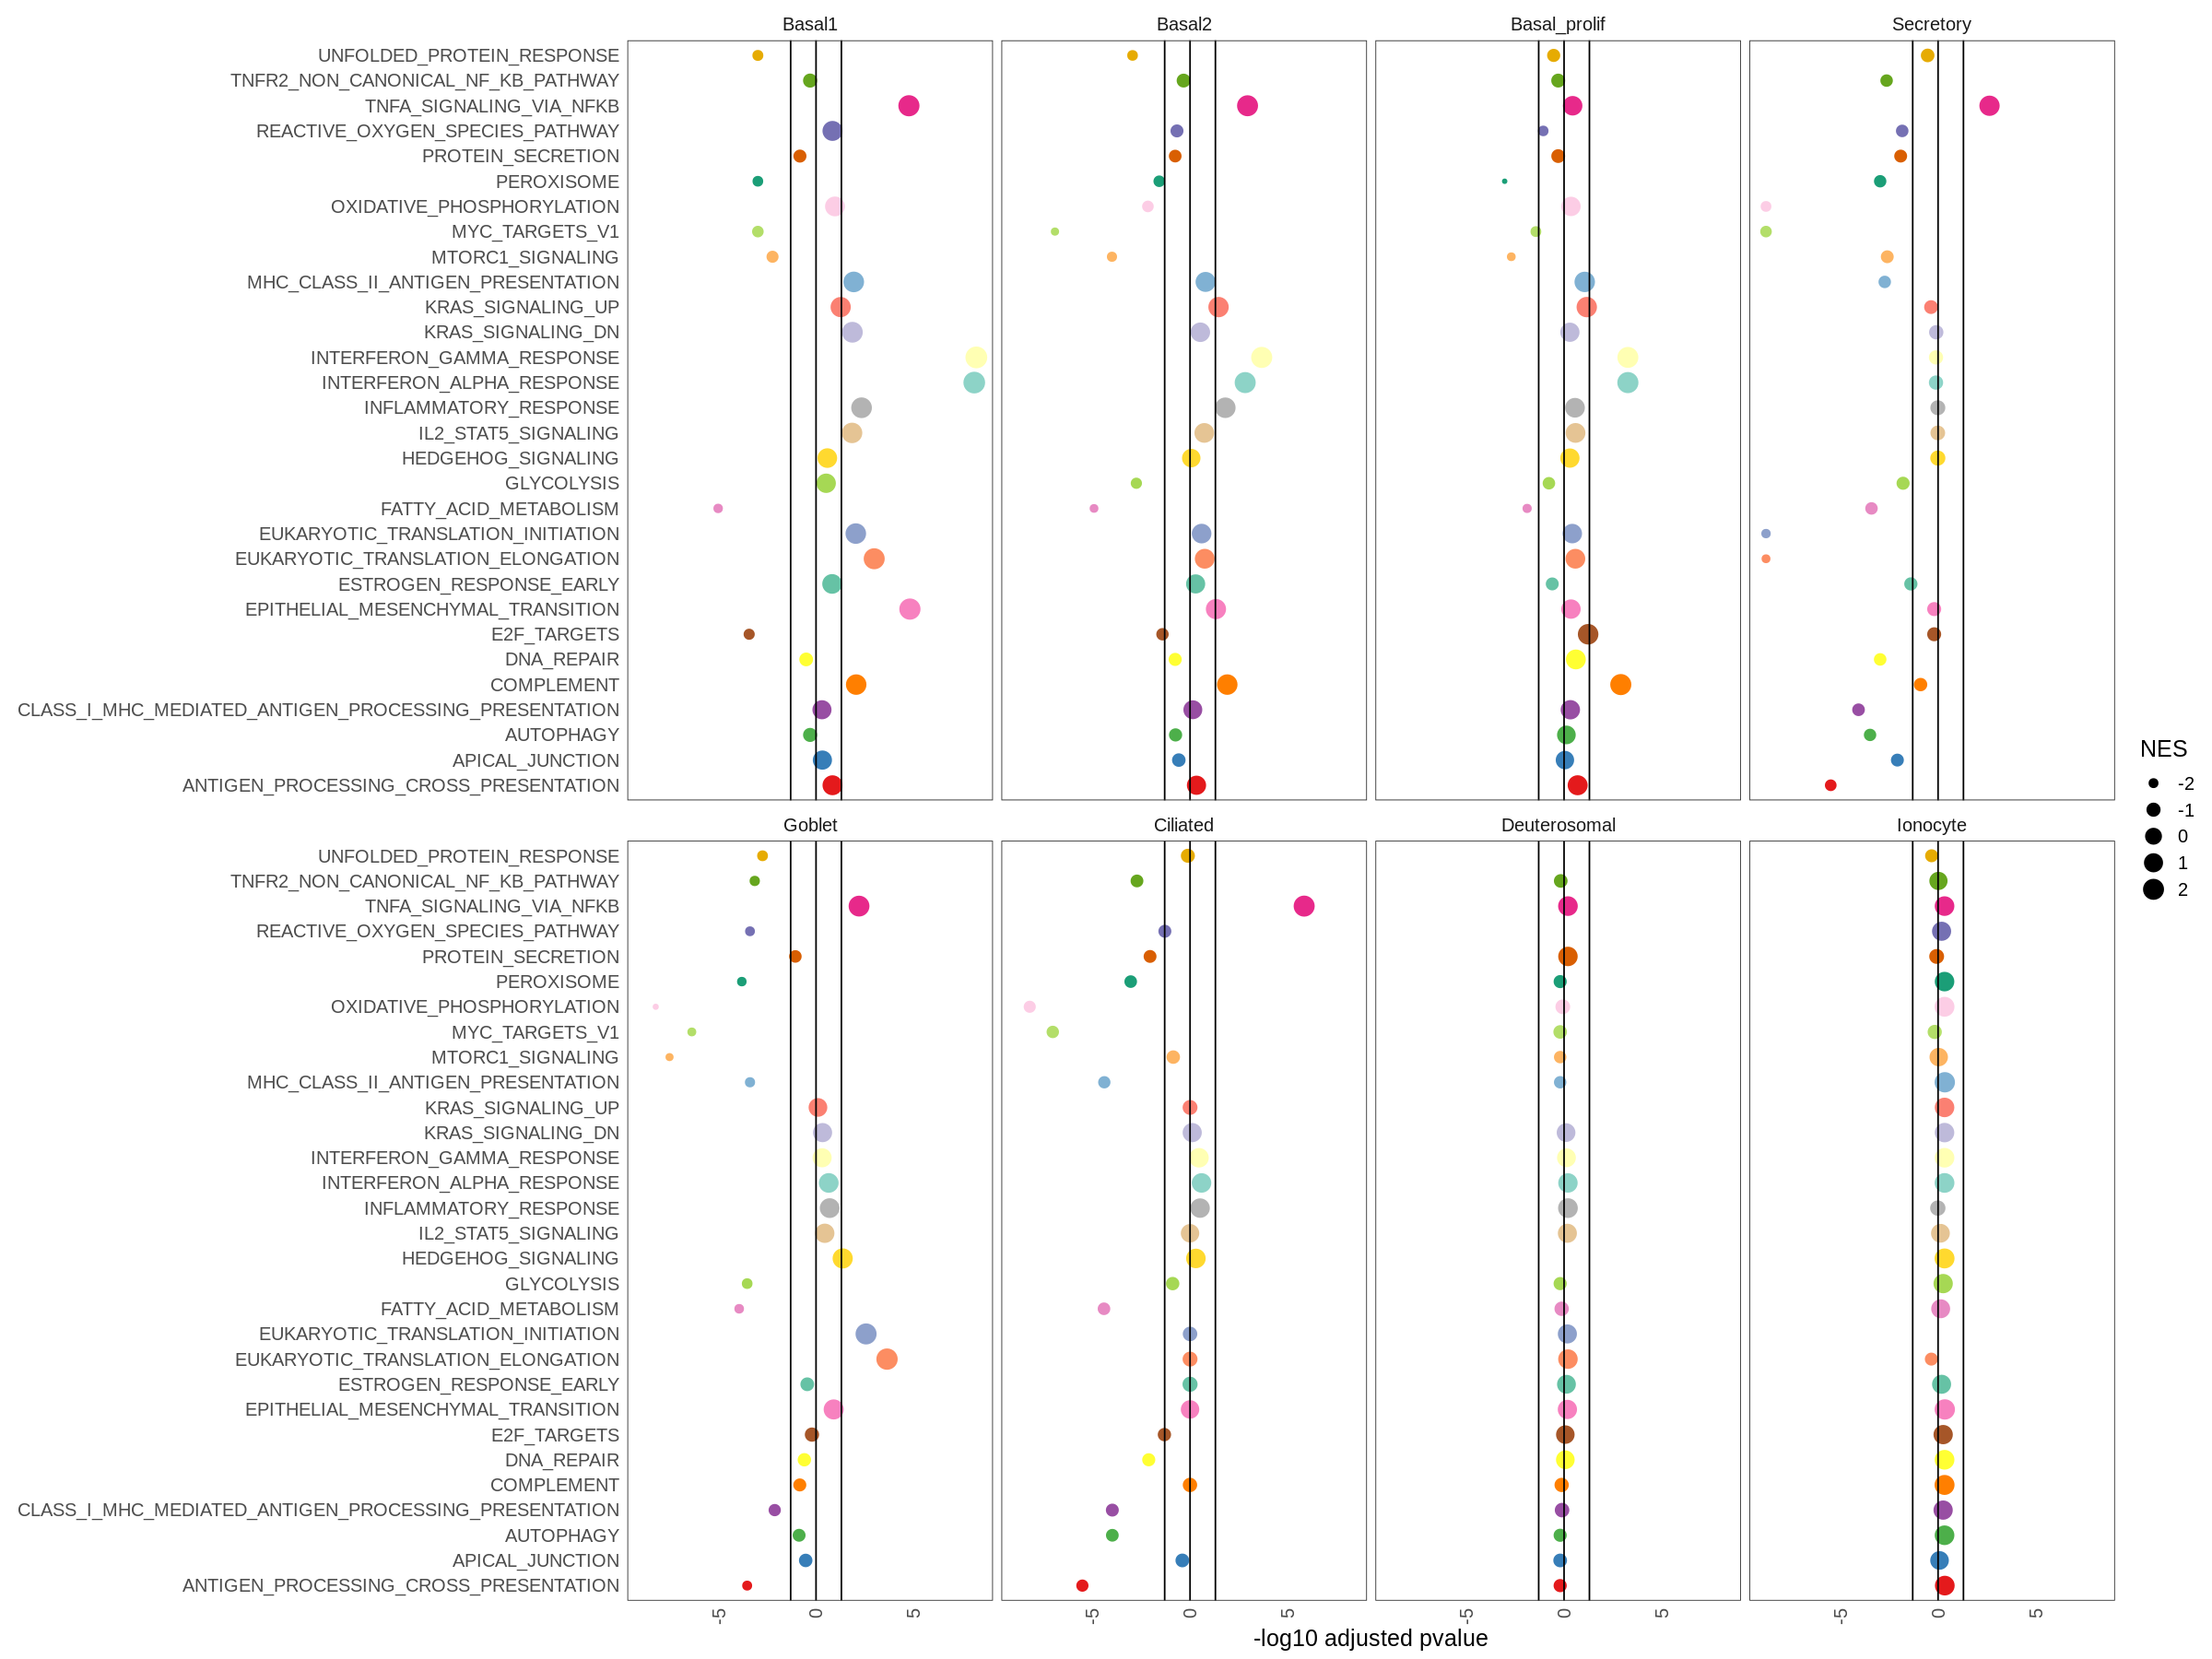

In [58]:
options(repr.plot.width=20, repr.plot.height=15)


ggplot(df5, aes(pathway, -log10(padj)*sign(NES), col = pathway, size = NES))+
geom_point()+facet_wrap(~celltype, ncol = 4)+ theme_bw() +
geom_hline(yintercept=1.3) +
geom_hline(yintercept=-1.3) +
geom_hline(yintercept=0) +

		theme(panel.grid.major = element_blank(), 
			panel.grid.minor = element_blank(), 
			panel.background = element_blank(), 
			axis.line = element_blank(), 
			axis.ticks = element_blank(),
            text = element_text(size=15),
            axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
#            legend.position = "none",
            strip.background = element_blank(),
             axis.title.y=element_blank())+
#            strip.text.x = element_text(colour = 'white', size = 20))+
	scale_color_manual(values=colour_list)+coord_flip()+ylab('-log10 adjusted pvalue')+guides(colour=FALSE)


setwd('/home/jovyan/data/covid_nasal/figures')
ggsave("gsea_covid_nasal_hallmark.png", plot = last_plot(), device = NULL, path = NULL,width = 20, height = 15,  scale = 1)